# 1. Twitch API data

The URL `https://wind-bow.glitch.me/twitch-api/channels/{CHANNEL_NAME}` is an API from twitch to get data from twitch channels.

Get the data from the following channels:

```
["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]
```

To make into a dataframe that looks like this:

![](twitch.png)

In [1]:
import requests
import pandas as pd
import json

# twitch channels
# some (eg. ninja) are not found when requested
CHANNELS = ["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]

# things to include in dataframe
INFO = ['_id','display_name','status','followers','views']

channels_list = []

for ch in CHANNELS:
    r = requests.get(f"https://wind-bow.glitch.me/twitch-api/channels/{ch}")
    js = json.loads(r.content)
    
    if 'error' not in js:
        channels_list.append({
            'id': js['_id'], 
            'display_name': js['display_name'], 
            'status': js['status'],
            'followers': js['followers'], 
            'views': js['views']
        })

df = pd.DataFrame(channels_list)
df

,id,display_name,status,followers,views
0,30220059,ESL_SC2,RERUN: StarCraft 2 - Terminator vs. Parting (P...,135394,60991791
1,71852806,OgamingSC2,UnderDogs - Rediffusion - Qualifier.,40895,20694507
2,90401618,cretetion,It's a Divison kind of Day,908,11631
3,79776140,FreeCodeCamp,Greg working on Electron-Vue boilerplate w/ Ak...,10122,163747
4,86238744,storbeck,None,10,1019
5,6726509,Habathcx,Massively Effective,14,764
6,54925078,RobotCaleb,Code wrangling,20,4602
7,82534701,noobs2ninjas,Building a new hackintosh for #programming and...,835,48102


# 2. App Store Reviews

The Apple app store has a `GET` API to get reviews on apps. The URL is:

```
https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json
```

Note that you need to provide:

- The country code (eg. `'us'`, `'gb'`, `'ca'`, `'au'`) 

- The app ID. This can be found in the web page for the app right after `id`. For instance, Candy Crush's US webpage is:

`https://apps.apple.com/us/app/candy-crush-saga/id553834731`

So here the ID would be `553834731`.

- The "Page Number". The request responds with multiple pages of data, but sends them one at a time. So you can cycle through the data pages for any app on any country.



In [2]:
code_dict = {
    "ae": "United Arab Emirates",
    "ag": "Antigua and Barbuda",
    "ai": "Anguilla",
    "al": "Albania",
    "am": "Armenia",
    "ao": "Angola",
    "ar": "Argentina",
    "at": "Austria",
    "au": "Australia",
    "az": "Azerbaijan",
    "bb": "Barbados",
    "be": "Belgium",
    "bf": "Burkina-Faso",
    "bg": "Bulgaria",
    "bh": "Bahrain",
    "bj": "Benin",
    "bm": "Bermuda",
    "bn": "Brunei Darussalam",
    "bo": "Bolivia",
    "br": "Brazil",
    "bs": "Bahamas",
    "bt": "Bhutan",
    "bw": "Botswana",
    "by": "Belarus",
    "bz": "Belize",
    "ca": "Canada",
    "cg": "Democratic Republic of the Congo",
    "ch": "Switzerland",
    "cl": "Chile",
    "cn": "China",
    "co": "Colombia",
    "cr": "Costa Rica",
    "cv": "Cape Verde",
    "cy": "Cyprus",
    "cz": "Czech Republic",
    "de": "Germany",
    "dk": "Denmark",
    "dm": "Dominica",
    "do": "Dominican Republic",
    "dz": "Algeria",
    "ec": "Ecuador",
    "ee": "Estonia",
    "eg": "Egypt",
    "es": "Spain",
    "fi": "Finland",
    "fj": "Fiji",
    "fm": "Federated States of Micronesia",
    "fr": "France",
    "gb": "Great Britain",
    "gd": "Grenada",
    "gh": "Ghana",
    "gm": "Gambia",
    "gr": "Greece",
    "gt": "Guatemala",
    "gw": "Guinea Bissau",
    "gy": "Guyana",
    "hk": "Hong Kong",
    "hn": "Honduras",
    "hr": "Croatia",
    "hu": "Hungaria",
    "id": "Indonesia",
    "ie": "Ireland",
    "il": "Israel",
    "in": "India",
    "is": "Iceland",
    "it": "Italy",
    "jm": "Jamaica",
    "jo": "Jordan",
    "jp": "Japan",
    "ke": "Kenya",
    "kg": "Krygyzstan",
    "kh": "Cambodia",
    "kn": "Saint Kitts and Nevis",
    "kr": "South Korea",
    "kw": "Kuwait",
    "ky": "Cayman Islands",
    "kz": "Kazakhstan",
    "la": "Laos",
    "lb": "Lebanon",
    "lc": "Saint Lucia",
    "lk": "Sri Lanka",
    "lr": "Liberia",
    "lt": "Lithuania",
    "lu": "Luxembourg",
    "lv": "Latvia",
    "md": "Moldova",
    "mg": "Madagascar",
    "mk": "Macedonia",
    "ml": "Mali",
    "mn": "Mongolia",
    "mo": "Macau",
    "mr": "Mauritania",
    "ms": "Montserrat",
    "mt": "Malta",
    "mu": "Mauritius",
    "mw": "Malawi",
    "mx": "Mexico",
    "my": "Malaysia",
    "mz": "Mozambique",
    "na": "Namibia",
    "ne": "Niger",
    "ng": "Nigeria",
    "ni": "Nicaragua",
    "nl": "Netherlands",
    "np": "Nepal",
    "no": "Norway",
    "nz": "New Zealand",
    "om": "Oman",
    "pa": "Panama",
    "pe": "Peru",
    "pg": "Papua New Guinea",
    "ph": "Philippines",
    "pk": "Pakistan",
    "pl": "Poland",
    "pt": "Portugal",
    "pw": "Palau",
    "py": "Paraguay",
    "qa": "Qatar",
    "ro": "Romania",
    "ru": "Russia",
    "sa": "Saudi Arabia",
    "sb": "Soloman Islands",
    "sc": "Seychelles",
    "se": "Sweden",
    "sg": "Singapore",
    "si": "Slovenia",
    "sk": "Slovakia",
    "sl": "Sierra Leone",
    "sn": "Senegal",
    "sr": "Suriname",
    "st": "Sao Tome e Principe",
    "sv": "El Salvador",
    "sz": "Swaziland",
    "tc": "Turks and Caicos Islands",
    "td": "Chad",
    "th": "Thailand",
    "tj": "Tajikistan",
    "tm": "Turkmenistan",
    "tn": "Tunisia",
    "tr": "Turkey",
    "tt": "Republic of Trinidad and Tobago",
    "tw": "Taiwan",
    "tz": "Tanzania",
    "ua": "Ukraine",
    "ug": "Uganda",
    "us": "United States of America",
    "uy": "Uruguay",
    "uz": "Uzbekistan",
    "vc": "Saint Vincent and the Grenadines",
    "ve": "Venezuela",
    "vg": "British Virgin Islands",
    "vn": "Vietnam",
    "ye": "Yemen",
    "za": "South Africa",
    "zw": "Zimbabwe"
}

eng_countries = [ 
'Antigua and Barbuda',
'Australia',
'Bahamas',
'Barbados',
'Belize',
'Canada',
'Dominica',
'Grenada',
'Guyana',
'Ireland',
'Jamaica',
'Malta',
'New Zealand',
'Saint Kitts and Nevis',
'Saint Lucia',
'Saint Vincent and the Grenadines',
'Republic of Trinidad and Tobago',
'Great Britain',
'United States of America'
]

code_dict_2 = {}
for e in list(code_dict):
    code_dict_2[code_dict[e]] = e

In [3]:
APPS = ['Candy_Crush','Facebook','Tinder','Twitter']

ID_dict = {
    'Candy_Crush' : '553834731',
    'Facebook' : '284882215',
    'Tinder' : '547702041',
    'Twitter' : '333903271' }

app_list = []
#reviews per page
per_page = 50

for app in APPS:
    # get app id
    APP_ID = ID_dict[app]

    for c in eng_countries:
        # get country codes for each eng-speaking country
        COUNTRY = code_dict_2[c]
        
        page = 1
        # loop thru pages 1-5
        while page < 6:
            try:
                r = requests.get(f"https://itunes.apple.com/{COUNTRY}/rss/customerreviews/id={APP_ID}/page={page}/sortby=mostrecent/json")
                js = json.loads(r.content)

                if 'error' not in js:
                    for i in range(per_page):
                        # construct and append entry to app_list
                        app_list.append({
                            'app': f'{app}',
                            'version': js['feed']['entry'][i]['im:version'], 
                            'rating': js['feed']['entry'][i]['im:rating'], 
                            'country': f'{COUNTRY}',
                            'title': js['feed']['entry'][i]['title'], 
                            'content': js['feed']['entry'][i]['content']
            })
                page += 1
            # escape loop if pages not found
            except:
                page = 6
                
dataframe = pd.DataFrame(app_list)

# cleaning
df = dataframe.copy()
cols = ['version', 'rating', 'title','content']
for c in cols:
    df[c] = df[c].str.get('label')

### 2.1 English app reviews

Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

In [4]:
df

,app,version,rating,country,title,content
0,Candy_Crush,1.178.0.3,3,ag,Not happy,Why i dont have some feature lile all my frien...
1,Candy_Crush,1.140.0,5,ag,10/10,Sometimes bittersweet but always await.
2,Candy_Crush,1.129.0,3,ag,Fishy,On more than one occasion I got a free spin to...
3,Candy_Crush,1.121.0,5,ag,Awesome,Fun game
4,Candy_Crush,1.49.0,5,ag,Cold,Definitely a one of a kind saga.i can't stop p...
...,...,...,...,...,...,...
8403,Twitter,8.54.5,1,us,Will not run right on the iPhone 12,Apparently no users exist when trying to use T...
8404,Twitter,8.54.5,1,us,Censorship and Pedophilia,They shut down my account in their ongoing cen...
8405,Twitter,8.54.5,5,us,Networking,"Less data , great speed and accessibility"
8406,Twitter,8.54.5,1,us,Worse update,I can’t log into the app because of some captc...


### 2.2 Best version

For each app, get the version that is the best rated.

Make a visualization of the ratings per versions per app to show this.

In [22]:
import matplotlib.pyplot as plt

df['rating'] = df['rating'].astype(int)

cc = df.loc[df['app'] == 'Candy_Crush'].copy()
tw = df.loc[df['app'] == 'Twitter'].copy()
fb = df.loc[df['app'] == 'Facebook'].copy()
tn = df.loc[df['app'] == 'Tinder'].copy()

# gr = versions grouped by major release for ease of viz
cc['gr'] = cc['version'].apply(lambda x : x.split('.')[1][0])
# ccg = candy crush grouped
ccg = cc.groupby(['gr'],as_index=False)['rating'].mean()

tw['gr'] = tw['version'].apply(lambda x : x.split('.')[0])
twg = tw.groupby(['gr'],as_index=False)['rating'].mean()
twg = twg.drop(0, axis=0)

fb['gr'] = fb['version'].apply(lambda x : x.split('.')[0][0])
fbg = fb.groupby(['gr'],as_index=False)['rating'].mean()

tn['gr'] = tn['version'].apply(lambda x : x.split('.')[0])
tng = tn.groupby(['gr'],as_index=False)['rating'].mean()
tng = tng.drop(0, axis=0)
tng['gr'] = tng['gr'].astype(int)
tng = tng.sort_values(by='gr', ascending=True)

Text(0.5, 1.0, 'Tinder')

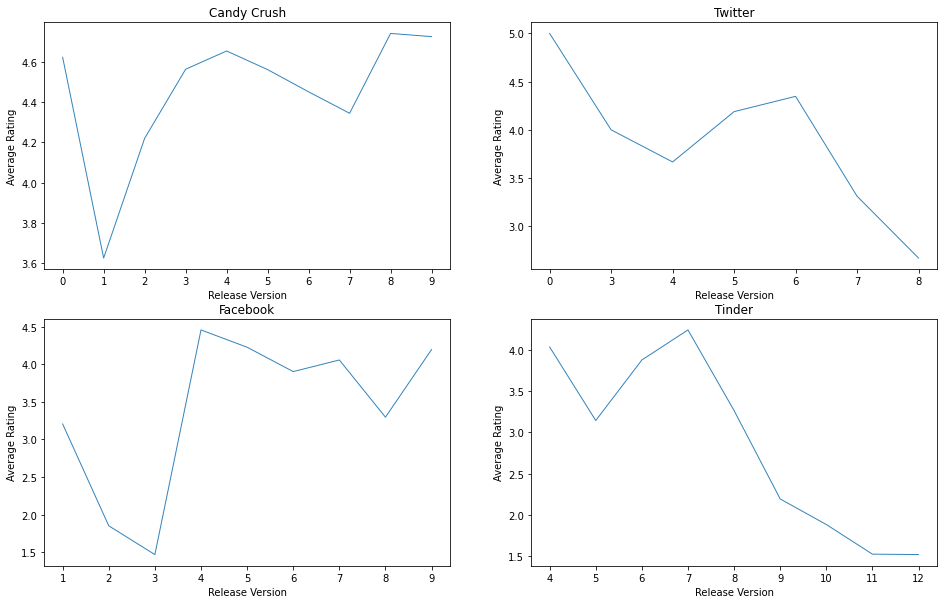

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))
for i in range(2):
    for j in range(2):
        ax[i][j].set_xlabel('Release Version')
        ax[i][j].set_ylabel('Average Rating')
ax[0][0].plot(ccg['gr'], ccg['rating'], linewidth=1, alpha=0.9) # candy crush
ax[0][1].plot(twg['gr'], twg['rating'], linewidth=1, alpha=0.9) # twitter
ax[1][0].plot(fbg['gr'], fbg['rating'], linewidth=1, alpha=0.9) # facebook
ax[1][1].plot(tng['gr'], tng['rating'], linewidth=1, alpha=0.9) # tinder
ax[0][0].set_title('Candy Crush')
ax[0][1].set_title('Twitter')
ax[1][0].set_title('Facebook')
ax[1][1].set_title('Tinder')

### 2.3 Top words

Which word for each app is most common in the 5 star and in the 1-star review's titles?

Note: `df.title.str.get_dummies()` is your friend

Note: This might create a lot of data! Try to break down your analysis in chunks if it doesn't work.

In [24]:
df['title'] = df['title'].str.lower()
df_1 = df.loc[df['rating'] == 1]
df_5 = df.loc[df['rating'] == 5]
df5 = df_5.title.str.get_dummies()
df1 = df_1.title.str.get_dummies()

In [25]:
df1.sum(axis = 0).idxmax(), df1.sum(axis = 0).max()

('censorship', 83)

In [26]:
df5.sum(axis = 0).idxmax(), df5.sum(axis = 0).max()

('candy crush', 132)

# 3 (STRETCH) IMDB scraping

IMDB has structured web pages. We can exploit this to scrape movie data.

Usinf the following URL:

`https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt`

With the following headers in your `GET` request: `{"Accept-Language": "en-US,en;q=0.5"}`

You can generate a dataframe like this one by cycling over the page numbers in the URL requested:

![](IMDB.png)

Note that the following  page attribues will be of interest:

- `div` with a class of `lister-item mode-advanced`

- Various `span` objects within that `div` like `lister-item-year` and `runtime` and `metascore`